## Gaussian noise 

Is a type of statistical noise that has a probability density function (PDF) equal to that of the normal distribution, which is also known as a Gaussian distribution. In simpler terms, it means that the noise values follow a bell-shaped curve when plotted. The noise is characterized by two main parameters:

Mean (μ): The average value of the noise. Gaussian noise typically has a mean of zero, which means it is centered around zero, with positive and negative values equally likely.

Standard Deviation (σ): This determines the spread or width of the bell curve. A larger standard deviation means the noise values can deviate more from the mean.
The mathematical form of the Gaussian distribution is:

![Gaussian distribution](../images/gaussian-noise.png)

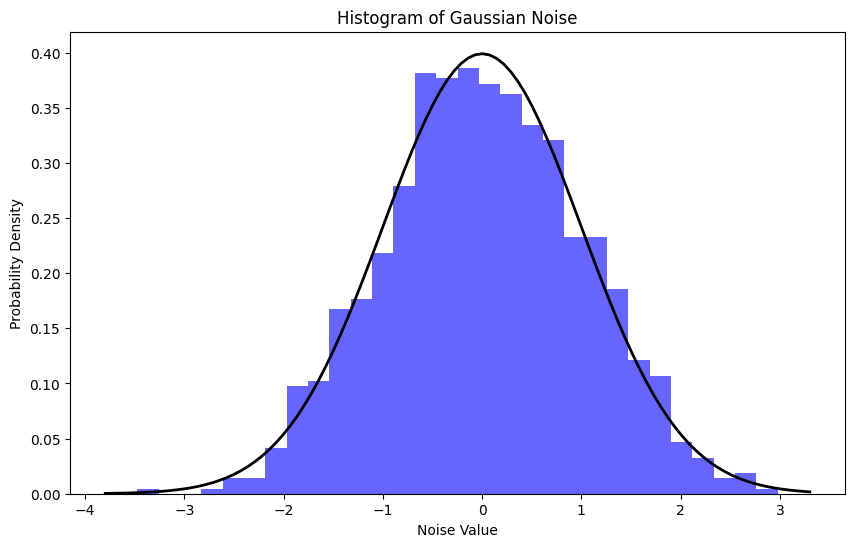

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for Gaussian noise
mean = 0       # Mean of the distribution
std_dev = 1    # Standard deviation of the distribution
num_samples = 1000  # Number of samples to generate

# Generate Gaussian noise
gaussian_noise = np.random.normal(mean, std_dev, num_samples)

# Plot the Gaussian noise
plt.figure(figsize=(10, 6))
plt.hist(gaussian_noise, bins=30, density=True, alpha=0.6, color='b')

# Plot the theoretical Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = (1 / (np.sqrt(2 * np.pi) * std_dev)) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
plt.plot(x, p, 'k', linewidth=2)

plt.title('Histogram of Gaussian Noise')
plt.xlabel('Noise Value')
plt.ylabel('Probability Density')
plt.show()


This code demonstrates the forward diffusion process in diffusion models.It progressively adds Gaussian noise to an input RGB image over a series of timesteps. The resulting noisy images are then visualized to illustrate how the original image is transformed into noise.

Gaussian noise's statistical properties, mathematical tractability, and ease of use make it an ideal choice for modeling the diffusion process in machine learning applications.

![fwd diffusion](../images/ddpm_fwd_diff.png) 

Img Source: Denoising diffusion probabilistic models. https://arxiv.org/pdf/2006.11239

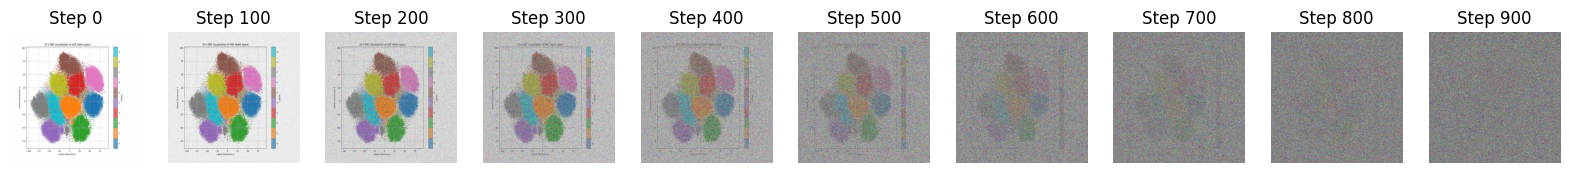

In [2]:
# Sample code for forward diffusion sampling

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms


# Set up parameters for diffusion
timesteps = 1000  # Number of diffusion steps
beta_start = 1e-4  # Small amount of initial noise
beta_end = 0.02    # Final amount of noise

# Create a linear schedule for beta values (variance of noise added at each step)
betas = torch.linspace(beta_start, beta_end, timesteps)

# Calculate alpha values based on betas
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

# Function for sampling Gaussian noise
def sample_gaussian_noise(shape):
    return torch.randn(shape)

# Forward diffusion sampling function
def forward_diffusion_sample(x_0, t):
    """
    Add noise to the input image x_0 at time step t.
    
    Parameters:
        x_0: Original image (batch of images)
        t: Time step (0 <= t < timesteps)
        
    Returns:
        Noisy image x_t
    """
     # Calculate scaling factors for original image and noise
    sqrt_alpha_cumprod_t = torch.sqrt(alphas_cumprod[t]).view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1 - alphas_cumprod[t]).view(-1, 1, 1, 1)
    noise = sample_gaussian_noise(x_0.shape)

    # Generate noisy image
    x_t = sqrt_alpha_cumprod_t * x_0 + sqrt_one_minus_alpha_cumprod_t * noise
    return x_t, noise

# Load and preprocess the sample image
image_path = 'latent_space.png'  # Replace with your image path
image = Image.open(image_path).convert('RGB')  # Keep the image in RGB format

# Transform the image to a tensor and normalize to range [-1, 1]
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),  # Resize for simplicity
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])
x_0 = transform(image).unsqueeze(0)  # Add batch dimension

# Sample noisy versions of the image at different time steps
noisy_images = []
num_steps_to_show = 10  # Number of steps to visualize
for i in range(0, timesteps, timesteps // num_steps_to_show):
    x_t, _ = forward_diffusion_sample(x_0, i)
    noisy_images.append(x_t.squeeze().permute(1, 2, 0).numpy())  # Change the shape to (H, W, C) for plotting

# Plot the original and progressively noisier images
fig, axes = plt.subplots(1, len(noisy_images), figsize=(20, 5))
for i, ax in enumerate(axes):
    # Convert back to the original pixel range [0, 255] for visualization
    img = (noisy_images[i] * 0.5 + 0.5).clip(0, 1)  # Scale to [0, 1]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Step {i * timesteps // num_steps_to_show}')
plt.show()


##### Why Scaling?

In Gaussian diffusion models, the square root scaling factor is applied to control the contributions of the original image and the noise during the forward diffusion process.

* The square root of the cumulative product of the alphas scales the original image. This scaling ensures that as more noise is added over time, the contribution of the original signal decreases relative to the noise, maintaining a balanced signal-to-noise ratio.

* The formula for adding noise in the diffusion process is given by:

![](../images/gauss-noise-add.png)
​
  
  The square root ensures that both components (the original image and the noise) are properly normalized, allowing the model to effectively learn the underlying distribution.

* By using the square root, the model can smoothly transition from the original image to pure noise as the timesteps increase, which is crucial for training the model effectively and for generating realistic samples later.

Overall, the square root scaling factor is essential for ensuring that the diffusion process remains controlled and mathematically sound throughout the noise addition steps.

#### Mini Diffusion model 

I have tried to implement a mini diffusion model. The model is based on Unet architecture with the reparameterization trick in the fwd diffusion process. During training, the random timesteps are generated in the range (0, num_steps=500) and passed to the model. The timesteps have a shape (batchsize,), which is resized to (batchsize, input_channels, 1,1) to match the input to downsample blocks. Sinusoidal function is used for the timestep encoding. The encoding is added to the input before downsampling. I have just added the encoding only to downsampling. It can be added to upsampling and bottlneck as well. There are two models one with the timestep encoding aware model and one without.

Unet - The model is not aware of the which timestep is used to generate noise in fwd diffusion
DiffModel - Timstep encoding is introduced in downsampling blocks only 

##### Just for the test!!! 
Hardware used for training 
intel i7-vpro 9th gen 16GB RAM

#### Training time per epoch
Unet : 30 minutes

DiffModel with ts encodings: 52 minutes

ONLY 10 epochs trained. 

Working Code - [Visit Github](https://github.com/Kunal627/kunal627.github.io/tree/main/code)


#### Further Reading

* Denoising Diffusion Probabilistic Models - https://arxiv.org/pdf/2006.11239
* How diffusion models work: the math from scratch  https://theaisummer.com/diffusion-models/?fbclid=IwAR1BIeNHqa3NtC8SL0sKXHATHklJYphNH-8IGNoO3xZhSKM_GYcvrrQgB0o
* The theory behind Latent Variable Models: formulating a Variational Autoencoder  https://theaisummer.com/latent-variable-models/#reparameterization-trick
* U-Net: Convolutional Networks for Biomedical Image Segmentation - https://arxiv.org/pdf/1505.04597
* Step by Step Visual Introduction to diffusion models - https://erdem.pl/2023/11/step-by-step-visual-introduction-to-diffusion-models